In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW


In [2]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

In [3]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(61-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )
        
    return tc

In [4]:
from datasets import Dataset
m = find_pad_max(tc_dataset["train"])
split="train"

In [5]:
tc = pad_data(tc_dataset[split], m=m, split=split)

In [6]:
train_dataset=Dataset.from_list(tc)

In [7]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 266
})

In [8]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [9]:
train_example =train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

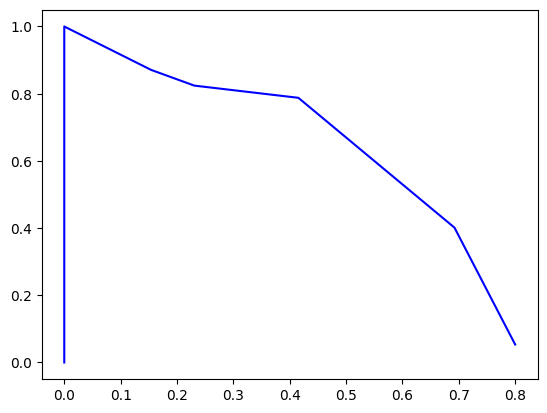

In [10]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], 
          train_example["feat_dynamic_real"][-num_of_samples:],
          color="blue")

plt.show()

In [11]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [12]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
# test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [13]:
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
# test_grouper = MultivariateGrouper(
#     max_target_dim=num_of_variates,
#     num_test_dates= None, # len(test_dataset)
#     num_of_variates  # number of rolling test windows
# )

multi_variate_train_dataset = train_grouper(train_dataset)
# multi_variate_test_dataset = test_grouper(test_dataset)

In [14]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (266, 99)


In [15]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x134b11300>, <function week_of_year at 0x134b116c0>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [16]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [17]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [18]:
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [19]:
model.config.distribution_output

'student_t'

In [20]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [21]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [22]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [23]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

In [24]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 266]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 266]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 266]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 266]) torch.FloatTensor


In [25]:
from tqdm import tqdm
epochs = 250
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-5, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):   
    for idx, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            print(f'Epoch {epoch} & idx {idx} with loss: {loss.item()}')

Epoch 1/250 : 1it [00:02,  2.02s/it, loss=-521]

Epoch 0 & idx 0 with loss: -520.8426513671875


Epoch 1/250 : 100it [00:32,  3.04it/s, loss=-637]
Epoch 2/250 : 1it [00:00,  4.12it/s, loss=-604]

Epoch 1 & idx 0 with loss: -568.7760009765625


Epoch 2/250 : 100it [00:34,  2.86it/s, loss=-714]
Epoch 3/250 : 1it [00:00,  2.88it/s, loss=-823]

Epoch 2 & idx 0 with loss: -831.4459838867188


Epoch 3/250 : 100it [00:32,  3.11it/s, loss=-784]
Epoch 4/250 : 1it [00:00,  3.15it/s, loss=-710]

Epoch 3 & idx 0 with loss: -723.0618286132812


Epoch 4/250 : 100it [00:30,  3.29it/s, loss=-836]
Epoch 5/250 : 1it [00:00,  3.33it/s, loss=-903]

Epoch 4 & idx 0 with loss: -862.5682373046875


Epoch 5/250 : 100it [00:31,  3.19it/s, loss=-872]
Epoch 6/250 : 1it [00:00,  2.84it/s, loss=-909]

Epoch 5 & idx 0 with loss: -872.56396484375


Epoch 6/250 : 100it [00:31,  3.20it/s, loss=-917]
Epoch 7/250 : 1it [00:00,  3.21it/s, loss=-1.01e+3]

Epoch 6 & idx 0 with loss: -983.702880859375


Epoch 7/250 : 100it [00:31,  3.18it/s, loss=-962]  
Epoch 8/250 : 1it [00:00,  2.94it/s, loss=-994]

Epoch 7 & idx 0 with loss: -906.5989990234375


Epoch 8/250 : 100it [00:31,  3.16it/s, loss=-998]   
Epoch 9/250 : 1it [00:00,  2.94it/s, loss=-1.02e+3]

Epoch 8 & idx 0 with loss: -998.8370361328125


Epoch 9/250 : 100it [00:31,  3.17it/s, loss=-1.02e+3]
Epoch 10/250 : 1it [00:00,  3.13it/s, loss=-1.01e+3]

Epoch 9 & idx 0 with loss: -1083.7022705078125


Epoch 10/250 : 100it [00:32,  3.10it/s, loss=-1.05e+3]
Epoch 11/250 : 1it [00:00,  2.92it/s, loss=-989]

Epoch 10 & idx 0 with loss: -981.2348022460938


Epoch 11/250 : 100it [00:32,  3.11it/s, loss=-1.07e+3]
Epoch 12/250 : 1it [00:00,  3.43it/s, loss=-1.03e+3]

Epoch 11 & idx 0 with loss: -1046.550048828125


Epoch 12/250 : 100it [00:31,  3.15it/s, loss=-1.09e+3]
Epoch 13/250 : 1it [00:00,  2.94it/s, loss=-1.11e+3]

Epoch 12 & idx 0 with loss: -1164.9244384765625


Epoch 13/250 : 100it [00:32,  3.12it/s, loss=-1.12e+3]
Epoch 14/250 : 1it [00:00,  3.00it/s, loss=-1.1e+3]

Epoch 13 & idx 0 with loss: -1101.0653076171875


Epoch 14/250 : 100it [00:32,  3.09it/s, loss=-1.13e+3]
Epoch 15/250 : 1it [00:00,  2.91it/s, loss=-1.08e+3]

Epoch 14 & idx 0 with loss: -1084.833740234375


Epoch 15/250 : 100it [00:32,  3.11it/s, loss=-1.15e+3]
Epoch 16/250 : 1it [00:00,  3.45it/s, loss=-1.16e+3]

Epoch 15 & idx 0 with loss: -1193.6748046875


Epoch 16/250 : 100it [00:31,  3.15it/s, loss=-1.17e+3]
Epoch 17/250 : 1it [00:00,  2.93it/s, loss=-1.13e+3]

Epoch 16 & idx 0 with loss: -1098.6455078125


Epoch 17/250 : 100it [00:31,  3.20it/s, loss=-1.17e+3]
Epoch 18/250 : 1it [00:00,  3.56it/s, loss=-1.19e+3]

Epoch 17 & idx 0 with loss: -1123.2037353515625


Epoch 18/250 : 100it [00:31,  3.14it/s, loss=-1.2e+3]
Epoch 19/250 : 1it [00:00,  3.88it/s, loss=-1.14e+3]

Epoch 18 & idx 0 with loss: -1137.4666748046875


Epoch 19/250 : 100it [00:31,  3.14it/s, loss=-1.21e+3]
Epoch 20/250 : 1it [00:00,  2.42it/s, loss=-1.12e+3]

Epoch 19 & idx 0 with loss: -1120.44091796875


Epoch 20/250 : 100it [00:32,  3.05it/s, loss=-1.21e+3]
Epoch 21/250 : 1it [00:00,  3.17it/s, loss=-1.26e+3]

Epoch 20 & idx 0 with loss: -1266.80029296875


Epoch 21/250 : 100it [00:31,  3.14it/s, loss=-1.23e+3]
Epoch 22/250 : 1it [00:00,  3.04it/s, loss=-1.2e+3] 

Epoch 21 & idx 0 with loss: -1276.11572265625


Epoch 22/250 : 100it [00:32,  3.12it/s, loss=-1.25e+3]
Epoch 23/250 : 1it [00:00,  2.99it/s, loss=-1.19e+3]

Epoch 22 & idx 0 with loss: -1164.4171142578125


Epoch 23/250 : 100it [00:31,  3.13it/s, loss=-1.25e+3]
Epoch 24/250 : 1it [00:00,  3.03it/s, loss=-1.23e+3]

Epoch 23 & idx 0 with loss: -1220.479736328125


Epoch 24/250 : 100it [00:31,  3.15it/s, loss=-1.27e+3]
Epoch 25/250 : 1it [00:00,  3.08it/s, loss=-1.19e+3]

Epoch 24 & idx 0 with loss: -1186.632080078125


Epoch 25/250 : 100it [00:32,  3.10it/s, loss=-1.26e+3]
Epoch 26/250 : 1it [00:00,  3.22it/s, loss=-1.25e+3]

Epoch 25 & idx 0 with loss: -1287.8836669921875


Epoch 26/250 : 100it [00:31,  3.14it/s, loss=-1.27e+3]
Epoch 27/250 : 1it [00:00,  2.97it/s, loss=-1.27e+3]

Epoch 26 & idx 0 with loss: -1225.150146484375


Epoch 27/250 : 100it [00:32,  3.10it/s, loss=-1.28e+3]
Epoch 28/250 : 1it [00:00,  3.01it/s, loss=-1.24e+3]

Epoch 27 & idx 0 with loss: -1208.05029296875


Epoch 28/250 : 100it [00:31,  3.16it/s, loss=-1.29e+3]
Epoch 29/250 : 1it [00:00,  3.41it/s, loss=-1.29e+3]

Epoch 28 & idx 0 with loss: -1320.935791015625


Epoch 29/250 : 100it [00:32,  3.08it/s, loss=-1.3e+3]
Epoch 30/250 : 1it [00:00,  2.97it/s, loss=-1.35e+3]

Epoch 29 & idx 0 with loss: -1314.53857421875


Epoch 30/250 : 100it [00:32,  3.12it/s, loss=-1.32e+3]
Epoch 31/250 : 1it [00:00,  3.43it/s, loss=-1.36e+3]

Epoch 30 & idx 0 with loss: -1353.08056640625


Epoch 31/250 : 100it [00:31,  3.19it/s, loss=-1.33e+3]
Epoch 32/250 : 1it [00:00,  3.34it/s, loss=-1.28e+3]

Epoch 31 & idx 0 with loss: -1243.5731201171875


Epoch 32/250 : 100it [00:31,  3.17it/s, loss=-1.31e+3]
Epoch 33/250 : 1it [00:00,  3.05it/s, loss=-1.3e+3] 

Epoch 32 & idx 0 with loss: -1363.424560546875


Epoch 33/250 : 100it [00:31,  3.17it/s, loss=-1.32e+3]
Epoch 34/250 : 1it [00:00,  3.39it/s, loss=-1.29e+3]

Epoch 33 & idx 0 with loss: -1280.97705078125


Epoch 34/250 : 100it [00:31,  3.16it/s, loss=-1.33e+3]
Epoch 35/250 : 1it [00:00,  2.81it/s, loss=-1.25e+3]

Epoch 34 & idx 0 with loss: -1156.40478515625


Epoch 35/250 : 100it [00:32,  3.10it/s, loss=-1.34e+3]
Epoch 36/250 : 1it [00:00,  2.94it/s, loss=-1.35e+3]

Epoch 35 & idx 0 with loss: -1415.2548828125


Epoch 36/250 : 100it [00:32,  3.10it/s, loss=-1.35e+3]
Epoch 37/250 : 1it [00:00,  3.07it/s, loss=-1.39e+3]

Epoch 36 & idx 0 with loss: -1458.7059326171875


Epoch 37/250 : 100it [00:32,  3.11it/s, loss=-1.35e+3]
Epoch 38/250 : 1it [00:00,  4.72it/s, loss=-1.22e+3]

Epoch 37 & idx 0 with loss: -1121.102294921875


Epoch 38/250 : 100it [00:34,  2.91it/s, loss=-1.35e+3]
Epoch 39/250 : 1it [00:00,  2.76it/s, loss=-1.3e+3]

Epoch 38 & idx 0 with loss: -1301.294921875


Epoch 39/250 : 100it [00:32,  3.05it/s, loss=-1.36e+3]
Epoch 40/250 : 1it [00:00,  3.58it/s, loss=-1.34e+3]

Epoch 39 & idx 0 with loss: -1383.72900390625


Epoch 40/250 : 100it [00:31,  3.17it/s, loss=-1.37e+3]
Epoch 41/250 : 1it [00:00,  3.25it/s, loss=-1.34e+3]

Epoch 40 & idx 0 with loss: -1279.7158203125


Epoch 41/250 : 100it [00:30,  3.28it/s, loss=-1.36e+3]
Epoch 42/250 : 1it [00:00,  3.27it/s, loss=-1.35e+3]

Epoch 41 & idx 0 with loss: -1367.490478515625


Epoch 42/250 : 100it [00:30,  3.24it/s, loss=-1.38e+3]
Epoch 43/250 : 1it [00:00,  3.15it/s, loss=-1.33e+3]

Epoch 42 & idx 0 with loss: -1358.1102294921875


Epoch 43/250 : 100it [00:32,  3.09it/s, loss=-1.39e+3]
Epoch 44/250 : 1it [00:00,  3.05it/s, loss=-1.39e+3]

Epoch 43 & idx 0 with loss: -1409.9986572265625


Epoch 44/250 : 100it [00:32,  3.09it/s, loss=-1.39e+3]
Epoch 45/250 : 1it [00:00,  3.09it/s, loss=-1.39e+3]

Epoch 44 & idx 0 with loss: -1385.8983154296875


Epoch 45/250 : 100it [00:32,  3.06it/s, loss=-1.39e+3]
Epoch 46/250 : 1it [00:00,  2.98it/s, loss=-1.39e+3]

Epoch 45 & idx 0 with loss: -1377.66650390625


Epoch 46/250 : 100it [00:32,  3.09it/s, loss=-1.39e+3]
Epoch 47/250 : 1it [00:00,  2.98it/s, loss=-1.39e+3]

Epoch 46 & idx 0 with loss: -1274.8414306640625


Epoch 47/250 : 100it [00:32,  3.05it/s, loss=-1.4e+3]
Epoch 48/250 : 1it [00:00,  3.07it/s, loss=-1.35e+3]

Epoch 47 & idx 0 with loss: -1342.407470703125


Epoch 48/250 : 100it [00:32,  3.05it/s, loss=-1.39e+3]
Epoch 49/250 : 1it [00:00,  3.25it/s, loss=-1.43e+3]

Epoch 48 & idx 0 with loss: -1419.34765625


Epoch 49/250 : 100it [00:32,  3.09it/s, loss=-1.41e+3]
Epoch 50/250 : 1it [00:00,  3.06it/s, loss=-1.43e+3]

Epoch 49 & idx 0 with loss: -1450.682861328125


Epoch 50/250 : 100it [00:32,  3.09it/s, loss=-1.4e+3]
Epoch 51/250 : 1it [00:00,  3.09it/s, loss=-1.47e+3]

Epoch 50 & idx 0 with loss: -1483.454345703125


Epoch 51/250 : 100it [00:32,  3.03it/s, loss=-1.41e+3]
Epoch 52/250 : 1it [00:00,  2.98it/s, loss=-1.46e+3]

Epoch 51 & idx 0 with loss: -1463.58154296875


Epoch 52/250 : 100it [00:32,  3.06it/s, loss=-1.41e+3]
Epoch 53/250 : 1it [00:00,  2.96it/s, loss=-1.51e+3]

Epoch 52 & idx 0 with loss: -1514.97216796875


Epoch 53/250 : 100it [00:32,  3.11it/s, loss=-1.42e+3]
Epoch 54/250 : 1it [00:00,  3.00it/s, loss=-1.4e+3] 

Epoch 53 & idx 0 with loss: -1334.7593994140625


Epoch 54/250 : 100it [00:32,  3.12it/s, loss=-1.42e+3]
Epoch 55/250 : 1it [00:00,  3.00it/s, loss=-1.41e+3]

Epoch 54 & idx 0 with loss: -1393.5511474609375


Epoch 55/250 : 100it [00:32,  3.08it/s, loss=-1.42e+3]
Epoch 56/250 : 1it [00:00,  2.72it/s, loss=-1.38e+3]

Epoch 55 & idx 0 with loss: -1362.370849609375


Epoch 56/250 : 100it [00:32,  3.06it/s, loss=-1.42e+3]
Epoch 57/250 : 1it [00:00,  3.33it/s, loss=-1.44e+3]

Epoch 56 & idx 0 with loss: -1406.3009033203125


Epoch 57/250 : 100it [00:32,  3.10it/s, loss=-1.43e+3]
Epoch 58/250 : 1it [00:00,  3.71it/s, loss=-1.38e+3]

Epoch 57 & idx 0 with loss: -1410.1195068359375


Epoch 58/250 : 100it [00:32,  3.10it/s, loss=-1.43e+3]
Epoch 59/250 : 1it [00:00,  3.09it/s, loss=-1.48e+3]

Epoch 58 & idx 0 with loss: -1412.8875732421875


Epoch 59/250 : 100it [00:32,  3.08it/s, loss=-1.44e+3]
Epoch 60/250 : 1it [00:00,  3.02it/s, loss=-1.45e+3]

Epoch 59 & idx 0 with loss: -1420.225830078125


Epoch 60/250 : 100it [00:32,  3.05it/s, loss=-1.42e+3]
Epoch 61/250 : 1it [00:00,  3.34it/s, loss=-1.47e+3]

Epoch 60 & idx 0 with loss: -1429.802978515625


Epoch 61/250 : 100it [00:32,  3.05it/s, loss=-1.44e+3]
Epoch 62/250 : 1it [00:00,  2.89it/s, loss=-1.42e+3]

Epoch 61 & idx 0 with loss: -1423.9058837890625


Epoch 62/250 : 100it [00:32,  3.11it/s, loss=-1.44e+3]
Epoch 63/250 : 1it [00:00,  2.92it/s, loss=-1.42e+3]

Epoch 62 & idx 0 with loss: -1417.7734375


Epoch 63/250 : 100it [00:32,  3.11it/s, loss=-1.44e+3]
Epoch 64/250 : 1it [00:00,  3.47it/s, loss=-1.4e+3] 

Epoch 63 & idx 0 with loss: -1339.384521484375


Epoch 64/250 : 100it [00:32,  3.05it/s, loss=-1.44e+3]
Epoch 65/250 : 1it [00:00,  3.35it/s, loss=-1.44e+3]

Epoch 64 & idx 0 with loss: -1357.3662109375


Epoch 65/250 : 100it [00:31,  3.14it/s, loss=-1.45e+3]
Epoch 66/250 : 1it [00:00,  2.87it/s, loss=-1.59e+3]

Epoch 65 & idx 0 with loss: -1653.423583984375


Epoch 66/250 : 100it [00:31,  3.15it/s, loss=-1.47e+3]
Epoch 67/250 : 1it [00:00,  3.15it/s, loss=-1.37e+3]

Epoch 66 & idx 0 with loss: -1397.9881591796875


Epoch 67/250 : 100it [00:31,  3.15it/s, loss=-1.47e+3]
Epoch 68/250 : 1it [00:00,  2.98it/s, loss=-1.41e+3]

Epoch 67 & idx 0 with loss: -1454.573974609375


Epoch 68/250 : 100it [00:31,  3.17it/s, loss=-1.47e+3]
Epoch 69/250 : 1it [00:00,  3.33it/s, loss=-1.53e+3]

Epoch 68 & idx 0 with loss: -1580.851318359375


Epoch 69/250 : 100it [00:35,  2.81it/s, loss=-1.46e+3]
Epoch 70/250 : 1it [00:00,  2.89it/s, loss=-1.4e+3]

Epoch 69 & idx 0 with loss: -1401.98291015625


Epoch 70/250 : 100it [00:32,  3.03it/s, loss=-1.47e+3]
Epoch 71/250 : 1it [00:00,  3.08it/s, loss=-1.51e+3]

Epoch 70 & idx 0 with loss: -1494.511962890625


Epoch 71/250 : 100it [00:32,  3.08it/s, loss=-1.48e+3]
Epoch 72/250 : 1it [00:00,  3.23it/s, loss=-1.44e+3]

Epoch 71 & idx 0 with loss: -1406.444091796875


Epoch 72/250 : 100it [00:32,  3.10it/s, loss=-1.47e+3]
Epoch 73/250 : 1it [00:00,  3.32it/s, loss=-1.45e+3]

Epoch 72 & idx 0 with loss: -1463.7408447265625


Epoch 73/250 : 100it [00:31,  3.16it/s, loss=-1.48e+3]
Epoch 74/250 : 1it [00:00,  2.75it/s, loss=-1.46e+3]

Epoch 73 & idx 0 with loss: -1472.16015625


Epoch 74/250 : 100it [00:32,  3.05it/s, loss=-1.48e+3]
Epoch 75/250 : 1it [00:00,  3.15it/s, loss=-1.55e+3]

Epoch 74 & idx 0 with loss: -1549.9840087890625


Epoch 75/250 : 100it [00:31,  3.14it/s, loss=-1.48e+3]
Epoch 76/250 : 1it [00:00,  3.06it/s, loss=-1.37e+3]

Epoch 75 & idx 0 with loss: -1368.33984375


Epoch 76/250 : 100it [00:32,  3.11it/s, loss=-1.49e+3]
Epoch 77/250 : 1it [00:00,  3.13it/s, loss=-1.49e+3]

Epoch 76 & idx 0 with loss: -1489.3397216796875


Epoch 77/250 : 100it [00:33,  3.01it/s, loss=-1.49e+3]
Epoch 78/250 : 1it [00:00,  2.71it/s, loss=-1.42e+3]

Epoch 77 & idx 0 with loss: -1410.842041015625


Epoch 78/250 : 100it [00:43,  2.27it/s, loss=-1.49e+3]
Epoch 79/250 : 1it [00:00,  3.03it/s, loss=-1.49e+3]

Epoch 78 & idx 0 with loss: -1468.522705078125


Epoch 79/250 : 100it [00:32,  3.08it/s, loss=-1.5e+3]
Epoch 80/250 : 1it [00:00,  2.44it/s, loss=-1.46e+3]

Epoch 79 & idx 0 with loss: -1443.734130859375


Epoch 80/250 : 100it [00:32,  3.06it/s, loss=-1.5e+3]
Epoch 81/250 : 1it [00:00,  3.01it/s, loss=-1.49e+3]

Epoch 80 & idx 0 with loss: -1477.936279296875


Epoch 81/250 : 100it [00:32,  3.07it/s, loss=-1.49e+3]
Epoch 82/250 : 1it [00:00,  4.01it/s, loss=-1.48e+3]

Epoch 81 & idx 0 with loss: -1514.690673828125


Epoch 82/250 : 100it [00:32,  3.11it/s, loss=-1.49e+3]
Epoch 83/250 : 1it [00:00,  3.05it/s, loss=-1.38e+3]

Epoch 82 & idx 0 with loss: -1375.76416015625


Epoch 83/250 : 100it [00:33,  2.97it/s, loss=-1.5e+3]
Epoch 84/250 : 1it [00:00,  2.72it/s, loss=-1.47e+3]

Epoch 83 & idx 0 with loss: -1472.7750244140625


Epoch 84/250 : 100it [00:32,  3.07it/s, loss=-1.51e+3]
Epoch 85/250 : 1it [00:00,  3.05it/s, loss=-1.47e+3]

Epoch 84 & idx 0 with loss: -1467.343994140625


Epoch 85/250 : 100it [00:33,  3.01it/s, loss=-1.5e+3]
Epoch 86/250 : 1it [00:00,  2.92it/s, loss=-1.46e+3]

Epoch 85 & idx 0 with loss: -1465.3494873046875


Epoch 86/250 : 100it [00:32,  3.06it/s, loss=-1.5e+3]
Epoch 87/250 : 1it [00:00,  3.16it/s, loss=-1.45e+3]

Epoch 86 & idx 0 with loss: -1423.48583984375


Epoch 87/250 : 100it [00:32,  3.04it/s, loss=-1.5e+3]
Epoch 88/250 : 1it [00:00,  3.14it/s, loss=-1.51e+3]

Epoch 87 & idx 0 with loss: -1520.470458984375


Epoch 88/250 : 100it [00:33,  2.96it/s, loss=-1.5e+3]
Epoch 89/250 : 1it [00:00,  3.34it/s, loss=-1.44e+3]

Epoch 88 & idx 0 with loss: -1422.1683349609375


Epoch 89/250 : 100it [00:33,  3.01it/s, loss=-1.52e+3]
Epoch 90/250 : 1it [00:00,  3.17it/s, loss=-1.57e+3]

Epoch 89 & idx 0 with loss: -1585.2353515625


Epoch 90/250 : 100it [00:32,  3.12it/s, loss=-1.52e+3]
Epoch 91/250 : 1it [00:00,  3.37it/s, loss=-1.58e+3]

Epoch 90 & idx 0 with loss: -1534.918212890625


Epoch 91/250 : 100it [00:32,  3.08it/s, loss=-1.52e+3]
Epoch 92/250 : 1it [00:00,  2.89it/s, loss=-1.57e+3]

Epoch 91 & idx 0 with loss: -1615.232177734375


Epoch 92/250 : 100it [00:32,  3.08it/s, loss=-1.53e+3]
Epoch 93/250 : 1it [00:00,  3.26it/s, loss=-1.54e+3]

Epoch 92 & idx 0 with loss: -1548.4375


Epoch 93/250 : 100it [00:32,  3.05it/s, loss=-1.52e+3]
Epoch 94/250 : 1it [00:00,  3.13it/s, loss=-1.56e+3]

Epoch 93 & idx 0 with loss: -1537.35595703125


Epoch 94/250 : 100it [00:32,  3.08it/s, loss=-1.53e+3]
Epoch 95/250 : 1it [00:00,  2.21it/s, loss=-1.49e+3]

Epoch 94 & idx 0 with loss: -1486.1507568359375


Epoch 95/250 : 100it [00:32,  3.05it/s, loss=-1.51e+3]
Epoch 96/250 : 1it [00:00,  2.90it/s, loss=-1.53e+3]

Epoch 95 & idx 0 with loss: -1507.797607421875


Epoch 96/250 : 100it [00:33,  3.00it/s, loss=-1.53e+3]
Epoch 97/250 : 1it [00:00,  2.90it/s, loss=-1.48e+3]

Epoch 96 & idx 0 with loss: -1527.97314453125


Epoch 97/250 : 100it [00:32,  3.04it/s, loss=-1.51e+3]
Epoch 98/250 : 1it [00:00,  3.06it/s, loss=-1.55e+3]

Epoch 97 & idx 0 with loss: -1593.676513671875


Epoch 98/250 : 100it [00:33,  3.00it/s, loss=-1.53e+3]
Epoch 99/250 : 1it [00:00,  3.76it/s, loss=-1.54e+3]

Epoch 98 & idx 0 with loss: -1533.20458984375


Epoch 99/250 : 100it [00:33,  3.01it/s, loss=-1.53e+3]
Epoch 100/250 : 1it [00:00,  3.50it/s, loss=-1.48e+3]

Epoch 99 & idx 0 with loss: -1353.8756103515625


Epoch 100/250 : 100it [00:33,  3.00it/s, loss=-1.53e+3]
Epoch 101/250 : 1it [00:00,  3.05it/s, loss=-1.49e+3]

Epoch 100 & idx 0 with loss: -1459.28466796875


Epoch 101/250 : 100it [00:33,  2.98it/s, loss=-1.52e+3]
Epoch 102/250 : 1it [00:00,  2.60it/s, loss=-1.54e+3]

Epoch 101 & idx 0 with loss: -1536.3992919921875


Epoch 102/250 : 100it [00:32,  3.11it/s, loss=-1.53e+3]
Epoch 103/250 : 1it [00:00,  3.46it/s, loss=-1.61e+3]

Epoch 102 & idx 0 with loss: -1629.6331787109375


Epoch 103/250 : 100it [00:32,  3.11it/s, loss=-1.53e+3]
Epoch 104/250 : 1it [00:00,  3.00it/s, loss=-1.57e+3]

Epoch 103 & idx 0 with loss: -1556.73974609375


Epoch 104/250 : 100it [00:32,  3.07it/s, loss=-1.54e+3]
Epoch 105/250 : 1it [00:00,  3.51it/s, loss=-1.56e+3]

Epoch 104 & idx 0 with loss: -1581.033935546875


Epoch 105/250 : 100it [00:32,  3.07it/s, loss=-1.54e+3]
Epoch 106/250 : 1it [00:00,  3.29it/s, loss=-1.53e+3]

Epoch 105 & idx 0 with loss: -1501.029296875


Epoch 106/250 : 100it [00:32,  3.09it/s, loss=-1.54e+3]
Epoch 107/250 : 1it [00:00,  3.12it/s, loss=-1.58e+3]

Epoch 106 & idx 0 with loss: -1654.48681640625


Epoch 107/250 : 100it [00:31,  3.14it/s, loss=-1.54e+3]
Epoch 108/250 : 1it [00:00,  3.11it/s, loss=-1.51e+3]

Epoch 107 & idx 0 with loss: -1495.240234375


Epoch 108/250 : 100it [00:32,  3.10it/s, loss=-1.56e+3]
Epoch 109/250 : 1it [00:00,  3.02it/s, loss=-1.49e+3]

Epoch 108 & idx 0 with loss: -1454.108154296875


Epoch 109/250 : 100it [00:32,  3.09it/s, loss=-1.53e+3]
Epoch 110/250 : 1it [00:00,  3.02it/s, loss=-1.54e+3]

Epoch 109 & idx 0 with loss: -1637.385498046875


Epoch 110/250 : 100it [00:32,  3.04it/s, loss=-1.55e+3]
Epoch 111/250 : 1it [00:00,  3.15it/s, loss=-1.51e+3]

Epoch 110 & idx 0 with loss: -1455.16455078125


Epoch 111/250 : 100it [00:32,  3.04it/s, loss=-1.56e+3]
Epoch 112/250 : 1it [00:00,  3.06it/s, loss=-1.52e+3]

Epoch 111 & idx 0 with loss: -1553.2569580078125


Epoch 112/250 : 100it [00:33,  3.01it/s, loss=-1.55e+3]
Epoch 113/250 : 1it [00:00,  3.07it/s, loss=-1.47e+3]

Epoch 112 & idx 0 with loss: -1431.65087890625


Epoch 113/250 : 100it [00:32,  3.04it/s, loss=-1.54e+3]
Epoch 114/250 : 1it [00:00,  2.71it/s, loss=-1.44e+3]

Epoch 113 & idx 0 with loss: -1438.198974609375


Epoch 114/250 : 100it [00:32,  3.08it/s, loss=-1.54e+3]
Epoch 115/250 : 1it [00:00,  3.03it/s, loss=-1.59e+3]

Epoch 114 & idx 0 with loss: -1525.472900390625


Epoch 115/250 : 100it [00:31,  3.13it/s, loss=-1.56e+3]
Epoch 116/250 : 1it [00:00,  3.06it/s, loss=-1.56e+3]

Epoch 115 & idx 0 with loss: -1540.177490234375


Epoch 116/250 : 100it [00:32,  3.11it/s, loss=-1.55e+3]
Epoch 117/250 : 1it [00:00,  2.77it/s, loss=-1.59e+3]

Epoch 116 & idx 0 with loss: -1552.6064453125


Epoch 117/250 : 100it [00:32,  3.10it/s, loss=-1.56e+3]
Epoch 118/250 : 1it [00:00,  3.13it/s, loss=-1.51e+3]

Epoch 117 & idx 0 with loss: -1371.678466796875


Epoch 118/250 : 100it [00:32,  3.06it/s, loss=-1.55e+3]
Epoch 119/250 : 1it [00:00,  4.16it/s, loss=-1.51e+3]

Epoch 118 & idx 0 with loss: -1425.405517578125


Epoch 119/250 : 100it [00:32,  3.05it/s, loss=-1.56e+3]
Epoch 120/250 : 1it [00:00,  3.03it/s, loss=-1.6e+3] 

Epoch 119 & idx 0 with loss: -1612.7164306640625


Epoch 120/250 : 100it [00:32,  3.10it/s, loss=-1.56e+3]
Epoch 121/250 : 1it [00:00,  3.43it/s, loss=-1.57e+3]

Epoch 120 & idx 0 with loss: -1584.8916015625


Epoch 121/250 : 100it [00:32,  3.06it/s, loss=-1.55e+3]
Epoch 122/250 : 1it [00:00,  3.11it/s, loss=-1.57e+3]

Epoch 121 & idx 0 with loss: -1501.3612060546875


Epoch 122/250 : 100it [00:33,  2.95it/s, loss=-1.56e+3]
Epoch 123/250 : 1it [00:00,  3.12it/s, loss=-1.61e+3]

Epoch 122 & idx 0 with loss: -1711.9669189453125


Epoch 123/250 : 100it [00:32,  3.04it/s, loss=-1.57e+3]
Epoch 124/250 : 1it [00:00,  3.10it/s, loss=-1.58e+3]

Epoch 123 & idx 0 with loss: -1541.92041015625


Epoch 124/250 : 100it [00:32,  3.06it/s, loss=-1.57e+3]
Epoch 125/250 : 1it [00:00,  3.10it/s, loss=-1.67e+3]

Epoch 124 & idx 0 with loss: -1696.4013671875


Epoch 125/250 : 100it [00:32,  3.06it/s, loss=-1.58e+3]
Epoch 126/250 : 1it [00:00,  3.00it/s, loss=-1.49e+3]

Epoch 125 & idx 0 with loss: -1504.658447265625


Epoch 126/250 : 100it [00:32,  3.08it/s, loss=-1.56e+3]
Epoch 127/250 : 1it [00:00,  2.82it/s, loss=-1.57e+3]

Epoch 126 & idx 0 with loss: -1592.82763671875


Epoch 127/250 : 100it [00:32,  3.12it/s, loss=-1.58e+3]
Epoch 128/250 : 1it [00:00,  3.27it/s, loss=-1.56e+3]

Epoch 127 & idx 0 with loss: -1555.830810546875


Epoch 128/250 : 100it [00:32,  3.12it/s, loss=-1.57e+3]
Epoch 129/250 : 1it [00:00,  3.37it/s, loss=-1.56e+3]

Epoch 128 & idx 0 with loss: -1596.5899658203125


Epoch 129/250 : 100it [00:32,  3.04it/s, loss=-1.56e+3]
Epoch 130/250 : 1it [00:00,  3.13it/s, loss=-1.57e+3]

Epoch 129 & idx 0 with loss: -1570.559814453125


Epoch 130/250 : 100it [00:32,  3.10it/s, loss=-1.57e+3]
Epoch 131/250 : 1it [00:00,  3.20it/s, loss=-1.6e+3] 

Epoch 130 & idx 0 with loss: -1623.3739013671875


Epoch 131/250 : 100it [00:31,  3.14it/s, loss=-1.59e+3]
Epoch 132/250 : 1it [00:00,  3.49it/s, loss=-1.51e+3]

Epoch 131 & idx 0 with loss: -1519.611083984375


Epoch 132/250 : 100it [00:32,  3.08it/s, loss=-1.57e+3]
Epoch 133/250 : 1it [00:00,  3.36it/s, loss=-1.63e+3]

Epoch 132 & idx 0 with loss: -1622.033447265625


Epoch 133/250 : 100it [00:32,  3.08it/s, loss=-1.58e+3]
Epoch 134/250 : 1it [00:00,  3.00it/s, loss=-1.62e+3]

Epoch 133 & idx 0 with loss: -1571.186279296875


Epoch 134/250 : 100it [00:32,  3.05it/s, loss=-1.57e+3]
Epoch 135/250 : 1it [00:00,  3.04it/s, loss=-1.6e+3] 

Epoch 134 & idx 0 with loss: -1558.322021484375


Epoch 135/250 : 100it [00:32,  3.06it/s, loss=-1.58e+3]
Epoch 136/250 : 1it [00:00,  3.05it/s, loss=-1.52e+3]

Epoch 135 & idx 0 with loss: -1522.4949951171875


Epoch 136/250 : 100it [00:31,  3.13it/s, loss=-1.58e+3]
Epoch 137/250 : 1it [00:00,  3.05it/s, loss=-1.54e+3]

Epoch 136 & idx 0 with loss: -1510.3572998046875


Epoch 137/250 : 100it [00:33,  3.03it/s, loss=-1.58e+3]
Epoch 138/250 : 1it [00:00,  3.13it/s, loss=-1.63e+3]

Epoch 137 & idx 0 with loss: -1693.706787109375


Epoch 138/250 : 100it [00:32,  3.07it/s, loss=-1.58e+3]
Epoch 139/250 : 1it [00:00,  3.03it/s, loss=-1.5e+3] 

Epoch 138 & idx 0 with loss: -1543.749267578125


Epoch 139/250 : 100it [00:32,  3.11it/s, loss=-1.58e+3]
Epoch 140/250 : 1it [00:00,  3.27it/s, loss=-1.51e+3]

Epoch 139 & idx 0 with loss: -1543.928466796875


Epoch 140/250 : 100it [00:32,  3.12it/s, loss=-1.58e+3]
Epoch 141/250 : 1it [00:00,  2.37it/s, loss=-1.53e+3]

Epoch 140 & idx 0 with loss: -1531.0831298828125


Epoch 141/250 : 100it [00:32,  3.10it/s, loss=-1.6e+3]
Epoch 142/250 : 1it [00:00,  2.97it/s, loss=-1.53e+3]

Epoch 141 & idx 0 with loss: -1569.396728515625


Epoch 142/250 : 100it [00:32,  3.09it/s, loss=-1.59e+3]
Epoch 143/250 : 1it [00:00,  3.31it/s, loss=-1.59e+3]

Epoch 142 & idx 0 with loss: -1657.6295166015625


Epoch 143/250 : 100it [00:32,  3.07it/s, loss=-1.58e+3]
Epoch 144/250 : 1it [00:00,  3.44it/s, loss=-1.56e+3]

Epoch 143 & idx 0 with loss: -1528.855224609375


Epoch 144/250 : 100it [00:32,  3.09it/s, loss=-1.6e+3]
Epoch 145/250 : 1it [00:00,  3.05it/s, loss=-1.67e+3]

Epoch 144 & idx 0 with loss: -1707.900390625


Epoch 145/250 : 100it [00:32,  3.06it/s, loss=-1.6e+3]
Epoch 146/250 : 1it [00:00,  3.08it/s, loss=-1.56e+3]

Epoch 145 & idx 0 with loss: -1596.559814453125


Epoch 146/250 : 100it [00:32,  3.08it/s, loss=-1.59e+3]
Epoch 147/250 : 1it [00:00,  3.08it/s, loss=-1.61e+3]

Epoch 146 & idx 0 with loss: -1599.9156494140625


Epoch 147/250 : 100it [00:33,  3.03it/s, loss=-1.59e+3]
Epoch 148/250 : 1it [00:00,  2.54it/s, loss=-1.7e+3] 

Epoch 147 & idx 0 with loss: -1726.832275390625


Epoch 148/250 : 100it [00:33,  3.03it/s, loss=-1.59e+3]
Epoch 149/250 : 1it [00:00,  2.88it/s, loss=-1.62e+3]

Epoch 148 & idx 0 with loss: -1605.42724609375


Epoch 149/250 : 100it [00:33,  3.02it/s, loss=-1.6e+3]
Epoch 150/250 : 1it [00:00,  2.95it/s, loss=-1.62e+3]

Epoch 149 & idx 0 with loss: -1673.702392578125


Epoch 150/250 : 100it [00:32,  3.10it/s, loss=-1.6e+3]
Epoch 151/250 : 1it [00:00,  3.31it/s, loss=-1.63e+3]

Epoch 150 & idx 0 with loss: -1647.42333984375


Epoch 151/250 : 100it [00:31,  3.21it/s, loss=-1.59e+3]
Epoch 152/250 : 1it [00:00,  3.41it/s, loss=-1.65e+3]

Epoch 151 & idx 0 with loss: -1623.727294921875


Epoch 152/250 : 100it [00:31,  3.16it/s, loss=-1.6e+3]
Epoch 153/250 : 1it [00:00,  3.82it/s, loss=-1.58e+3]

Epoch 152 & idx 0 with loss: -1567.5784912109375


Epoch 153/250 : 100it [00:33,  3.02it/s, loss=-1.6e+3]
Epoch 154/250 : 1it [00:00,  3.26it/s, loss=-1.59e+3]

Epoch 153 & idx 0 with loss: -1569.8800048828125


Epoch 154/250 : 100it [00:33,  2.96it/s, loss=-1.61e+3]
Epoch 155/250 : 1it [00:00,  3.30it/s, loss=-1.54e+3]

Epoch 154 & idx 0 with loss: -1543.646240234375


Epoch 155/250 : 100it [00:33,  2.97it/s, loss=-1.61e+3]
Epoch 156/250 : 1it [00:00,  3.10it/s, loss=-1.58e+3]

Epoch 155 & idx 0 with loss: -1513.9573974609375


Epoch 156/250 : 100it [00:32,  3.07it/s, loss=-1.61e+3]
Epoch 157/250 : 1it [00:00,  2.96it/s, loss=-1.64e+3]

Epoch 156 & idx 0 with loss: -1623.7686767578125


Epoch 157/250 : 100it [00:34,  2.94it/s, loss=-1.61e+3]
Epoch 158/250 : 1it [00:00,  2.93it/s, loss=-1.59e+3]

Epoch 157 & idx 0 with loss: -1609.438232421875


Epoch 158/250 : 100it [00:33,  3.02it/s, loss=-1.6e+3]
Epoch 159/250 : 1it [00:00,  2.84it/s, loss=-1.68e+3]

Epoch 158 & idx 0 with loss: -1739.035888671875


Epoch 159/250 : 100it [00:32,  3.05it/s, loss=-1.6e+3]
Epoch 160/250 : 1it [00:00,  3.72it/s, loss=-1.61e+3]

Epoch 159 & idx 0 with loss: -1612.53662109375


Epoch 160/250 : 100it [00:32,  3.03it/s, loss=-1.61e+3]
Epoch 161/250 : 1it [00:00,  3.25it/s, loss=-1.65e+3]

Epoch 160 & idx 0 with loss: -1627.8575439453125


Epoch 161/250 : 100it [00:32,  3.08it/s, loss=-1.6e+3]
Epoch 162/250 : 1it [00:00,  3.02it/s, loss=-1.54e+3]

Epoch 161 & idx 0 with loss: -1502.7572021484375


Epoch 162/250 : 100it [00:33,  3.03it/s, loss=-1.62e+3]
Epoch 163/250 : 1it [00:00,  2.93it/s, loss=-1.61e+3]

Epoch 162 & idx 0 with loss: -1669.052734375


Epoch 163/250 : 100it [00:32,  3.07it/s, loss=-1.6e+3]
Epoch 164/250 : 1it [00:00,  2.99it/s, loss=-1.56e+3]

Epoch 163 & idx 0 with loss: -1579.445068359375


Epoch 164/250 : 100it [00:32,  3.12it/s, loss=-1.6e+3]
Epoch 165/250 : 1it [00:00,  2.94it/s, loss=-1.65e+3]

Epoch 164 & idx 0 with loss: -1650.86767578125


Epoch 165/250 : 100it [00:33,  3.00it/s, loss=-1.6e+3]
Epoch 166/250 : 1it [00:00,  3.03it/s, loss=-1.71e+3]

Epoch 165 & idx 0 with loss: -1764.723876953125


Epoch 166/250 : 100it [00:33,  3.00it/s, loss=-1.62e+3]
Epoch 167/250 : 1it [00:00,  2.87it/s, loss=-1.53e+3]

Epoch 166 & idx 0 with loss: -1532.760498046875


Epoch 167/250 : 100it [00:33,  3.01it/s, loss=-1.62e+3]
Epoch 168/250 : 1it [00:00,  2.80it/s, loss=-1.66e+3]

Epoch 167 & idx 0 with loss: -1655.750244140625


Epoch 168/250 : 100it [00:31,  3.15it/s, loss=-1.62e+3]
Epoch 169/250 : 1it [00:00,  3.11it/s, loss=-1.66e+3]

Epoch 168 & idx 0 with loss: -1621.2857666015625


Epoch 169/250 : 100it [00:31,  3.17it/s, loss=-1.63e+3]
Epoch 170/250 : 1it [00:00,  3.19it/s, loss=-1.66e+3]

Epoch 169 & idx 0 with loss: -1618.2386474609375


Epoch 170/250 : 100it [00:31,  3.16it/s, loss=-1.63e+3]
Epoch 171/250 : 1it [00:00,  3.52it/s, loss=-1.72e+3]

Epoch 170 & idx 0 with loss: -1776.956298828125


Epoch 171/250 : 100it [00:31,  3.18it/s, loss=-1.62e+3]
Epoch 172/250 : 1it [00:00,  3.07it/s, loss=-1.64e+3]

Epoch 171 & idx 0 with loss: -1621.5897216796875


Epoch 172/250 : 100it [00:32,  3.12it/s, loss=-1.62e+3]
Epoch 173/250 : 1it [00:00,  3.24it/s, loss=-1.65e+3]

Epoch 172 & idx 0 with loss: -1752.0230712890625


Epoch 173/250 : 100it [00:32,  3.05it/s, loss=-1.62e+3]
Epoch 174/250 : 1it [00:00,  3.58it/s, loss=-1.69e+3]

Epoch 173 & idx 0 with loss: -1636.528076171875


Epoch 174/250 : 100it [00:33,  2.95it/s, loss=-1.62e+3]
Epoch 175/250 : 1it [00:00,  3.20it/s, loss=-1.59e+3]

Epoch 174 & idx 0 with loss: -1564.1278076171875


Epoch 175/250 : 100it [00:33,  2.96it/s, loss=-1.61e+3]
Epoch 176/250 : 1it [00:00,  3.08it/s, loss=-1.57e+3]

Epoch 175 & idx 0 with loss: -1492.86376953125


Epoch 176/250 : 100it [00:33,  3.00it/s, loss=-1.64e+3]
Epoch 177/250 : 1it [00:00,  3.36it/s, loss=-1.55e+3]

Epoch 176 & idx 0 with loss: -1485.476806640625


Epoch 177/250 : 100it [00:32,  3.08it/s, loss=-1.62e+3]
Epoch 178/250 : 1it [00:00,  3.11it/s, loss=-1.67e+3]

Epoch 177 & idx 0 with loss: -1660.9559326171875


Epoch 178/250 : 100it [00:33,  3.03it/s, loss=-1.62e+3]
Epoch 179/250 : 1it [00:00,  2.78it/s, loss=-1.66e+3]

Epoch 178 & idx 0 with loss: -1723.541015625


Epoch 179/250 : 100it [00:31,  3.15it/s, loss=-1.63e+3]
Epoch 180/250 : 1it [00:00,  3.48it/s, loss=-1.64e+3]

Epoch 179 & idx 0 with loss: -1656.701416015625


Epoch 180/250 : 100it [00:32,  3.10it/s, loss=-1.63e+3]
Epoch 181/250 : 1it [00:00,  3.16it/s, loss=-1.63e+3]

Epoch 180 & idx 0 with loss: -1604.1318359375


Epoch 181/250 : 100it [00:32,  3.10it/s, loss=-1.64e+3]
Epoch 182/250 : 1it [00:00,  3.39it/s, loss=-1.57e+3]

Epoch 181 & idx 0 with loss: -1571.2669677734375


Epoch 182/250 : 100it [00:32,  3.04it/s, loss=-1.62e+3]
Epoch 183/250 : 1it [00:00,  3.27it/s, loss=-1.63e+3]

Epoch 182 & idx 0 with loss: -1671.0753173828125


Epoch 183/250 : 100it [00:34,  2.90it/s, loss=-1.62e+3]
Epoch 184/250 : 1it [00:00,  3.02it/s, loss=-1.63e+3]

Epoch 183 & idx 0 with loss: -1627.860595703125


Epoch 184/250 : 100it [00:32,  3.05it/s, loss=-1.61e+3]
Epoch 185/250 : 1it [00:00,  2.93it/s, loss=-1.63e+3]

Epoch 184 & idx 0 with loss: -1736.9161376953125


Epoch 185/250 : 100it [00:33,  3.02it/s, loss=-1.63e+3]
Epoch 186/250 : 1it [00:00,  3.37it/s, loss=-1.6e+3] 

Epoch 185 & idx 0 with loss: -1592.025390625


Epoch 186/250 : 100it [00:32,  3.07it/s, loss=-1.63e+3]
Epoch 187/250 : 1it [00:00,  3.24it/s, loss=-1.52e+3]

Epoch 186 & idx 0 with loss: -1520.4837646484375


Epoch 187/250 : 100it [00:33,  3.02it/s, loss=-1.63e+3]
Epoch 188/250 : 1it [00:00,  2.96it/s, loss=-1.64e+3]

Epoch 187 & idx 0 with loss: -1669.96826171875


Epoch 188/250 : 100it [00:32,  3.04it/s, loss=-1.63e+3]
Epoch 189/250 : 1it [00:00,  3.66it/s, loss=-1.6e+3] 

Epoch 188 & idx 0 with loss: -1660.272216796875


Epoch 189/250 : 100it [00:32,  3.06it/s, loss=-1.63e+3]
Epoch 190/250 : 1it [00:00,  3.26it/s, loss=-1.69e+3]

Epoch 189 & idx 0 with loss: -1697.209716796875


Epoch 190/250 : 100it [00:31,  3.19it/s, loss=-1.62e+3]
Epoch 191/250 : 1it [00:00,  2.94it/s, loss=-1.62e+3]

Epoch 190 & idx 0 with loss: -1616.162109375


Epoch 191/250 : 100it [00:32,  3.12it/s, loss=-1.62e+3]
Epoch 192/250 : 1it [00:00,  3.07it/s, loss=-1.64e+3]

Epoch 191 & idx 0 with loss: -1715.5966796875


Epoch 192/250 : 100it [00:32,  3.11it/s, loss=-1.64e+3]
Epoch 193/250 : 1it [00:00,  2.83it/s, loss=-1.58e+3]

Epoch 192 & idx 0 with loss: -1601.11474609375


Epoch 193/250 : 100it [00:32,  3.07it/s, loss=-1.64e+3]
Epoch 194/250 : 1it [00:00,  2.90it/s, loss=-1.53e+3]

Epoch 193 & idx 0 with loss: -1545.2222900390625


Epoch 194/250 : 100it [00:32,  3.04it/s, loss=-1.63e+3]
Epoch 195/250 : 1it [00:00,  3.24it/s, loss=-1.68e+3]

Epoch 194 & idx 0 with loss: -1648.1998291015625


Epoch 195/250 : 100it [00:33,  3.00it/s, loss=-1.63e+3]
Epoch 196/250 : 1it [00:00,  2.80it/s, loss=-1.71e+3]

Epoch 195 & idx 0 with loss: -1685.1510009765625


Epoch 196/250 : 100it [00:33,  3.01it/s, loss=-1.64e+3]
Epoch 197/250 : 1it [00:00,  3.64it/s, loss=-1.48e+3]

Epoch 196 & idx 0 with loss: -1336.5880126953125


Epoch 197/250 : 100it [00:32,  3.08it/s, loss=-1.63e+3]
Epoch 198/250 : 1it [00:00,  2.93it/s, loss=-1.65e+3]

Epoch 197 & idx 0 with loss: -1645.20263671875


Epoch 198/250 : 100it [00:32,  3.08it/s, loss=-1.64e+3]
Epoch 199/250 : 1it [00:00,  3.00it/s, loss=-1.65e+3]

Epoch 198 & idx 0 with loss: -1655.94775390625


Epoch 199/250 : 100it [00:34,  2.92it/s, loss=-1.65e+3]
Epoch 200/250 : 1it [00:00,  3.16it/s, loss=-1.7e+3] 

Epoch 199 & idx 0 with loss: -1726.5504150390625


Epoch 200/250 : 100it [00:32,  3.05it/s, loss=-1.64e+3]
Epoch 201/250 : 1it [00:00,  3.00it/s, loss=-1.68e+3]

Epoch 200 & idx 0 with loss: -1664.468505859375


Epoch 201/250 : 100it [00:32,  3.05it/s, loss=-1.66e+3]
Epoch 202/250 : 1it [00:00,  3.40it/s, loss=-1.63e+3]

Epoch 201 & idx 0 with loss: -1651.6455078125


Epoch 202/250 : 100it [00:32,  3.09it/s, loss=-1.65e+3]
Epoch 203/250 : 1it [00:00,  2.91it/s, loss=-1.69e+3]

Epoch 202 & idx 0 with loss: -1678.9031982421875


Epoch 203/250 : 100it [00:34,  2.94it/s, loss=-1.64e+3]
Epoch 204/250 : 1it [00:00,  2.45it/s, loss=-1.66e+3]

Epoch 203 & idx 0 with loss: -1660.51318359375


Epoch 204/250 : 100it [00:40,  2.45it/s, loss=-1.63e+3]
Epoch 205/250 : 1it [00:00,  3.08it/s, loss=-1.55e+3]

Epoch 204 & idx 0 with loss: -1551.7808837890625


Epoch 205/250 : 100it [00:33,  3.01it/s, loss=-1.63e+3]
Epoch 206/250 : 1it [00:00,  2.98it/s, loss=-1.62e+3]

Epoch 205 & idx 0 with loss: -1618.626220703125


Epoch 206/250 : 100it [00:32,  3.12it/s, loss=-1.64e+3]
Epoch 207/250 : 1it [00:00,  3.56it/s, loss=-1.57e+3]

Epoch 206 & idx 0 with loss: -1548.7957763671875


Epoch 207/250 : 100it [00:33,  2.99it/s, loss=-1.65e+3]
Epoch 208/250 : 1it [00:00,  2.82it/s, loss=-1.66e+3]

Epoch 207 & idx 0 with loss: -1658.12548828125


Epoch 208/250 : 100it [00:32,  3.09it/s, loss=-1.65e+3]
Epoch 209/250 : 1it [00:00,  3.23it/s, loss=-1.63e+3]

Epoch 208 & idx 0 with loss: -1574.066162109375


Epoch 209/250 : 100it [00:32,  3.10it/s, loss=-1.66e+3]
Epoch 210/250 : 1it [00:00,  3.37it/s, loss=-1.64e+3]

Epoch 209 & idx 0 with loss: -1678.2181396484375


Epoch 210/250 : 100it [00:32,  3.11it/s, loss=-1.65e+3]
Epoch 211/250 : 1it [00:00,  2.88it/s, loss=-1.74e+3]

Epoch 210 & idx 0 with loss: -1696.25830078125


Epoch 211/250 : 100it [00:31,  3.15it/s, loss=-1.64e+3]
Epoch 212/250 : 1it [00:00,  2.62it/s, loss=-1.72e+3]

Epoch 211 & idx 0 with loss: -1721.517578125


Epoch 212/250 : 100it [00:32,  3.06it/s, loss=-1.64e+3]
Epoch 213/250 : 1it [00:00,  3.16it/s, loss=-1.59e+3]

Epoch 212 & idx 0 with loss: -1487.32275390625


Epoch 213/250 : 100it [00:32,  3.10it/s, loss=-1.66e+3]
Epoch 214/250 : 1it [00:00,  3.11it/s, loss=-1.62e+3]

Epoch 213 & idx 0 with loss: -1643.78759765625


Epoch 214/250 : 100it [00:32,  3.07it/s, loss=-1.64e+3]
Epoch 215/250 : 1it [00:00,  2.77it/s, loss=-1.73e+3]

Epoch 214 & idx 0 with loss: -1682.9259033203125


Epoch 215/250 : 100it [00:32,  3.05it/s, loss=-1.66e+3]
Epoch 216/250 : 1it [00:00,  2.96it/s, loss=-1.64e+3]

Epoch 215 & idx 0 with loss: -1608.91162109375


Epoch 216/250 : 100it [00:33,  3.01it/s, loss=-1.65e+3]
Epoch 217/250 : 1it [00:00,  2.88it/s, loss=-1.67e+3]

Epoch 216 & idx 0 with loss: -1710.3974609375


Epoch 217/250 : 100it [00:34,  2.89it/s, loss=-1.67e+3]
Epoch 218/250 : 1it [00:00,  2.87it/s, loss=-1.6e+3] 

Epoch 217 & idx 0 with loss: -1646.344970703125


Epoch 218/250 : 100it [00:32,  3.03it/s, loss=-1.64e+3]
Epoch 219/250 : 1it [00:00,  2.98it/s, loss=-1.64e+3]

Epoch 218 & idx 0 with loss: -1657.115966796875


Epoch 219/250 : 100it [00:33,  3.00it/s, loss=-1.66e+3]
Epoch 220/250 : 1it [00:00,  2.73it/s, loss=-1.51e+3]

Epoch 219 & idx 0 with loss: -1569.101318359375


Epoch 220/250 : 100it [00:33,  3.01it/s, loss=-1.66e+3]
Epoch 221/250 : 1it [00:00,  2.29it/s, loss=-1.62e+3]

Epoch 220 & idx 0 with loss: -1624.0150146484375


Epoch 221/250 : 100it [00:33,  2.95it/s, loss=-1.66e+3]
Epoch 222/250 : 1it [00:00,  2.97it/s, loss=-1.68e+3]

Epoch 221 & idx 0 with loss: -1683.970703125


Epoch 222/250 : 100it [00:33,  2.97it/s, loss=-1.67e+3]
Epoch 223/250 : 1it [00:00,  2.85it/s, loss=-1.61e+3]

Epoch 222 & idx 0 with loss: -1591.510986328125


Epoch 223/250 : 100it [00:32,  3.05it/s, loss=-1.65e+3]
Epoch 224/250 : 1it [00:00,  3.21it/s, loss=-1.58e+3]

Epoch 223 & idx 0 with loss: -1575.535888671875


Epoch 224/250 : 100it [00:33,  3.02it/s, loss=-1.65e+3]
Epoch 225/250 : 1it [00:00,  3.35it/s, loss=-1.73e+3]

Epoch 224 & idx 0 with loss: -1700.072509765625


Epoch 225/250 : 100it [00:32,  3.08it/s, loss=-1.65e+3]
Epoch 226/250 : 1it [00:00,  2.73it/s, loss=-1.64e+3]

Epoch 225 & idx 0 with loss: -1612.1220703125


Epoch 226/250 : 100it [00:32,  3.03it/s, loss=-1.66e+3]
Epoch 227/250 : 1it [00:00,  3.41it/s, loss=-1.62e+3]

Epoch 226 & idx 0 with loss: -1616.0751953125


Epoch 227/250 : 100it [00:32,  3.05it/s, loss=-1.66e+3]
Epoch 228/250 : 1it [00:00,  3.27it/s, loss=-1.66e+3]

Epoch 227 & idx 0 with loss: -1666.57177734375


Epoch 228/250 : 100it [00:32,  3.09it/s, loss=-1.66e+3]
Epoch 229/250 : 1it [00:00,  3.13it/s, loss=-1.64e+3]

Epoch 228 & idx 0 with loss: -1568.499755859375


Epoch 229/250 : 100it [00:33,  3.03it/s, loss=-1.67e+3]
Epoch 230/250 : 1it [00:00,  2.89it/s, loss=-1.73e+3]

Epoch 229 & idx 0 with loss: -1785.434326171875


Epoch 230/250 : 100it [00:33,  2.99it/s, loss=-1.66e+3]
Epoch 231/250 : 1it [00:00,  3.43it/s, loss=-1.62e+3]

Epoch 230 & idx 0 with loss: -1617.3134765625


Epoch 231/250 : 100it [00:33,  3.00it/s, loss=-1.67e+3]
Epoch 232/250 : 1it [00:00,  3.05it/s, loss=-1.6e+3] 

Epoch 231 & idx 0 with loss: -1554.3037109375


Epoch 232/250 : 100it [00:33,  2.95it/s, loss=-1.67e+3]
Epoch 233/250 : 1it [00:00,  2.14it/s, loss=-1.63e+3]

Epoch 232 & idx 0 with loss: -1629.049560546875


Epoch 233/250 : 100it [00:32,  3.05it/s, loss=-1.67e+3]
Epoch 234/250 : 1it [00:00,  3.09it/s, loss=-1.7e+3] 

Epoch 233 & idx 0 with loss: -1776.2794189453125


Epoch 234/250 : 100it [00:34,  2.92it/s, loss=-1.67e+3]
Epoch 235/250 : 1it [00:00,  2.84it/s, loss=-1.74e+3]

Epoch 234 & idx 0 with loss: -1729.108154296875


Epoch 235/250 : 100it [00:34,  2.91it/s, loss=-1.67e+3]
Epoch 236/250 : 1it [00:00,  2.90it/s, loss=-1.66e+3]

Epoch 235 & idx 0 with loss: -1664.85205078125


Epoch 236/250 : 100it [00:32,  3.05it/s, loss=-1.67e+3]
Epoch 237/250 : 1it [00:00,  2.95it/s, loss=-1.73e+3]

Epoch 236 & idx 0 with loss: -1728.3341064453125


Epoch 237/250 : 100it [00:32,  3.09it/s, loss=-1.68e+3]
Epoch 238/250 : 1it [00:00,  3.08it/s, loss=-1.68e+3]

Epoch 237 & idx 0 with loss: -1696.454833984375


Epoch 238/250 : 100it [00:32,  3.09it/s, loss=-1.69e+3]
Epoch 239/250 : 1it [00:00,  3.51it/s, loss=-1.56e+3]

Epoch 238 & idx 0 with loss: -1532.0263671875


Epoch 239/250 : 100it [00:32,  3.12it/s, loss=-1.67e+3]
Epoch 240/250 : 1it [00:00,  3.03it/s, loss=-1.65e+3]

Epoch 239 & idx 0 with loss: -1575.4683837890625


Epoch 240/250 : 100it [00:32,  3.12it/s, loss=-1.67e+3]
Epoch 241/250 : 1it [00:00,  3.24it/s, loss=-1.67e+3]

Epoch 240 & idx 0 with loss: -1604.2684326171875


Epoch 241/250 : 100it [00:31,  3.13it/s, loss=-1.69e+3]
Epoch 242/250 : 1it [00:00,  3.00it/s, loss=-1.69e+3]

Epoch 241 & idx 0 with loss: -1673.681640625


Epoch 242/250 : 100it [00:32,  3.04it/s, loss=-1.68e+3]
Epoch 243/250 : 1it [00:00,  2.92it/s, loss=-1.61e+3]

Epoch 242 & idx 0 with loss: -1657.8482666015625


Epoch 243/250 : 100it [00:31,  3.14it/s, loss=-1.66e+3]
Epoch 244/250 : 1it [00:00,  3.39it/s, loss=-1.61e+3]

Epoch 243 & idx 0 with loss: -1603.640869140625


Epoch 244/250 : 100it [00:32,  3.04it/s, loss=-1.67e+3]
Epoch 245/250 : 1it [00:00,  3.22it/s, loss=-1.65e+3]

Epoch 244 & idx 0 with loss: -1683.04931640625


Epoch 245/250 : 100it [00:32,  3.04it/s, loss=-1.68e+3]
Epoch 246/250 : 1it [00:00,  3.11it/s, loss=-1.58e+3]

Epoch 245 & idx 0 with loss: -1544.3809814453125


Epoch 246/250 : 100it [00:32,  3.10it/s, loss=-1.67e+3]
Epoch 247/250 : 1it [00:00,  3.24it/s, loss=-1.73e+3]

Epoch 246 & idx 0 with loss: -1739.0006103515625


Epoch 247/250 : 100it [00:32,  3.04it/s, loss=-1.68e+3]
Epoch 248/250 : 1it [00:00,  3.02it/s, loss=-1.62e+3]

Epoch 247 & idx 0 with loss: -1583.718505859375


Epoch 248/250 : 100it [00:33,  3.00it/s, loss=-1.68e+3]
Epoch 249/250 : 1it [00:00,  2.34it/s, loss=-1.67e+3]

Epoch 248 & idx 0 with loss: -1662.986572265625


Epoch 249/250 : 100it [00:32,  3.08it/s, loss=-1.67e+3]
Epoch 250/250 : 1it [00:00,  3.25it/s, loss=-1.62e+3]

Epoch 249 & idx 0 with loss: -1697.3819580078125


Epoch 250/250 : 100it [00:31,  3.16it/s, loss=-1.69e+3]


In [26]:
import os
work_dir = os.getcwd()
work_dir = os.getcwd()
data_dir = work_dir.replace("GitHub/RocketPill/ipynb-notebooks", "Data/")

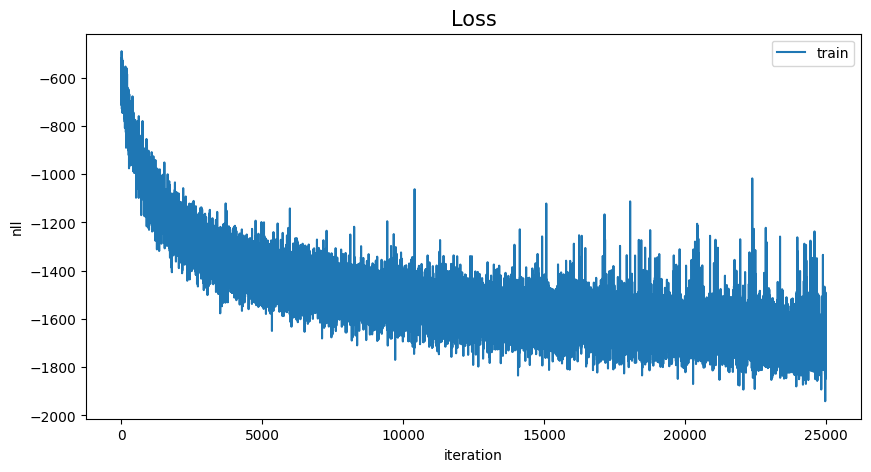

In [27]:
# view training
from datetime import datetime

loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.savefig(data_dir+"hf_informer4roqeto_loss_curve_"+str(datetime.now()).replace(":",".")+".png")
plt.show()

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [30]:
model.push_to_hub("shaddie/rocketpill_ts_informer_model",
                  use_auth_token=True,
                  commit_message="training-time-series-thrust-curve",
                  private=False)

/Users/rckyi/miniforge3/envs/gpu_py311/lib/python3.11/site-packages/transformers/utils/hub.py:907: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shaddie/rocketpill_ts_informer_model/commit/88f1d8b0198ef267492bd2546d522274f7c477b7', commit_message='training-time-series-thrust-curve', commit_description='', oid='88f1d8b0198ef267492bd2546d522274f7c477b7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shaddie/rocketpill_ts_informer_model', endpoint='https://huggingface.co', repo_type='model', repo_id='shaddie/rocketpill_ts_informer_model'), pr_revision=None, pr_num=None)